# Example 1: LSTM example on 1D signal


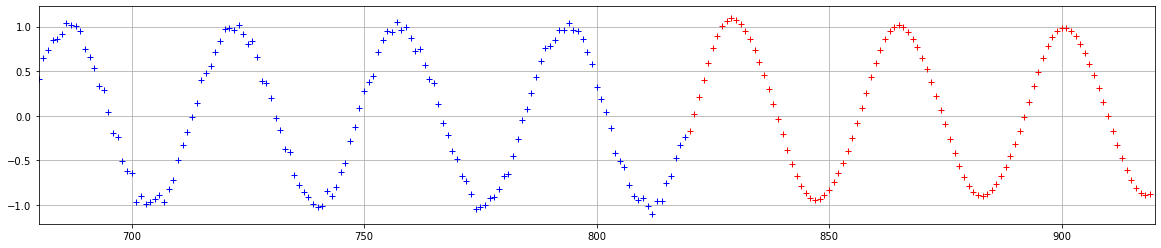

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Data preparation

In [2]:
# Shape definition
Di = 1  # shape of one element of the sequence
Do = 1  # output shape
L = 20  # Sequence size
n_seq = 800 # number of sequences generated

Nb of generated samples:  820


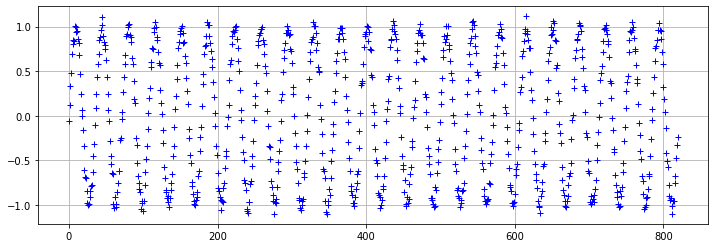

In [3]:
# Data is generated from a sine function to which a certain level of noise is added: 
noise_level=0.05

# Create sequential data:
x = torch.linspace(0,n_seq+L, n_seq+L)
noise=torch.randn(n_seq+L)*noise_level
data = torch.sin(x * 2 * np.pi / 35.7)+noise
print('Nb of generated samples: ',len(data))

# Visualisation
plt.figure(figsize = (12,4))
plt.grid(True)
plt.plot(data.numpy(),'+b')

In [4]:
def build_dataset(donnees, seq_size, test_split=0.1):
    N = len(donnees) 
    nb_seq = N-seq_size
    print('Total number of sequences : ', nb_seq)
    n_test = int(test_split*nb_seq)
    n_train = nb_seq-n_test
    x_train = torch.zeros((n_train,seq_size))  
    x_test = torch.zeros((n_test,seq_size)) 
    y_train= torch.zeros((n_train) )
    y_test = torch.zeros((n_test))      
    for i in range(n_train):
        sequence = donnees[i:i+seq_size]
        label = donnees[i+seq_size]
        x_train[i,:]=sequence
        y_train[i]=label 
    print('Number of training sequences : ', n_train)
    k=0
    for i in range(n_train,n_train+n_test):
        sequence = donnees[i:seq_size+i]
        label = donnees[seq_size+i]
        x_test[k,:]=sequence
        y_test[k]=label
        k+=1        
    print('Number of testing sequences : ', n_test)
    return (x_train,y_train), (x_test,y_test)

In [5]:
# Creation of dataset
(x_train,y_train), (x_test,y_test)=build_dataset(data, seq_size=L, test_split=0.1)
print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_test : ', x_test.shape)
print('y_test : ', y_test.shape)

# Dataset pytorch
train_data = TensorDataset(x_train,y_train)
test_data = TensorDataset(x_test,y_test)

Total number of sequences :  800
Number of training sequences :  720
Number of testing sequences :  80
x_train :  torch.Size([720, 20])
y_train :  torch.Size([720])
x_test :  torch.Size([80, 20])
y_test :  torch.Size([80])


## 2. Model creation

In [6]:
class myLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)  # FC layer between hidden layer and output

    def forward(self, seq):          
        batch_size = seq.size(0)
        seq_size = seq.size(1)
        #input shape : [batch_size, seq_size,input_size] = [1,20,1]
        lstm_out, (ht, ct) = self.lstm(seq) 
        #output shape : [batch_size, seq_size, hidden_size] = [1,20,50]
        pred = self.fc(lstm_out[:,-1,:])  
        #print('shape pred: ',pred.shape)
        return pred[:,0]  

In [7]:
H = 64 # hidden layer size
N = 16 # batch size
lr = 0.01  # learning_rate

# FILL HERE
model = myLSTM(input_size=Di, hidden_size=H, out_size=Do)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=N, shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=len(x_test), shuffle=False)

print(model)

myLSTM(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### Print parameter size

In [8]:
print("--- State_dict du model : ---")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print()

--- State_dict du model : ---
lstm.weight_ih_l0 	 torch.Size([256, 1])
lstm.weight_hh_l0 	 torch.Size([256, 64])
lstm.bias_ih_l0 	 torch.Size([256])
lstm.bias_hh_l0 	 torch.Size([256])
fc.weight 	 torch.Size([1, 64])
fc.bias 	 torch.Size([1])



## 3. Training

In [9]:
losses=[]
epochs = 80
for i in range(epochs):
    for features, labels in train_loader: 
        optimizer.zero_grad()        
        y_pred = model(features[:,:,None]) 
        loss = loss_function(y_pred, labels)        
        loss.backward()        
        optimizer.step()
        losses.append(loss.item()) 
    
    print('[Epoch : %d] loss: %.4f'%(i + 1,loss.item()))

[Epoch : 1] loss: 0.5673
[Epoch : 2] loss: 0.4329
[Epoch : 3] loss: 0.3563
[Epoch : 4] loss: 0.3515
[Epoch : 5] loss: 0.3489
[Epoch : 6] loss: 0.1455
[Epoch : 7] loss: 0.1071
[Epoch : 8] loss: 0.1213
[Epoch : 9] loss: 0.0858
[Epoch : 10] loss: 0.0822
[Epoch : 11] loss: 0.0688
[Epoch : 12] loss: 0.0628
[Epoch : 13] loss: 0.0812
[Epoch : 14] loss: 0.0678
[Epoch : 15] loss: 0.0667
[Epoch : 16] loss: 0.0625
[Epoch : 17] loss: 0.0457
[Epoch : 18] loss: 0.0368
[Epoch : 19] loss: 0.0477
[Epoch : 20] loss: 0.0462
[Epoch : 21] loss: 0.0357
[Epoch : 22] loss: 0.0518
[Epoch : 23] loss: 0.0409
[Epoch : 24] loss: 0.0393
[Epoch : 25] loss: 0.0469
[Epoch : 26] loss: 0.0432
[Epoch : 27] loss: 0.0269
[Epoch : 28] loss: 0.0327
[Epoch : 29] loss: 0.0343
[Epoch : 30] loss: 0.0157
[Epoch : 31] loss: 0.0318
[Epoch : 32] loss: 0.0272
[Epoch : 33] loss: 0.0395
[Epoch : 34] loss: 0.0277
[Epoch : 35] loss: 0.0230
[Epoch : 36] loss: 0.0210
[Epoch : 37] loss: 0.0152
[Epoch : 38] loss: 0.0116
[Epoch : 39] loss: 0.

### Display loss function

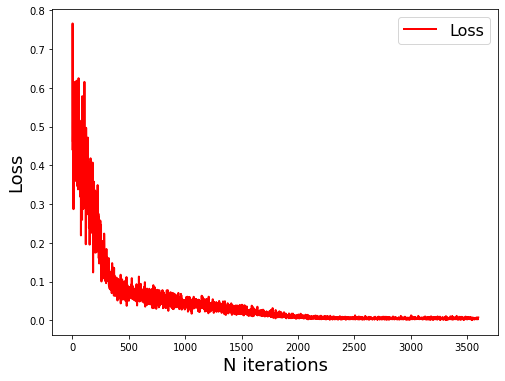

In [10]:
def display(losses,label='Loss'):
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label=label)
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Loss',fontsize=18)
    plt.legend(loc='upper right',fontsize=16)

# Display loss
display(losses)

### Visualisation of results on test sequences

In [11]:
#Predictions
with torch.no_grad(): # no need to compute gradients here
    predictions = model(x_test[:,:,None])  

print('shape predictions: ',predictions.shape)


shape predictions:  torch.Size([80])


720
80


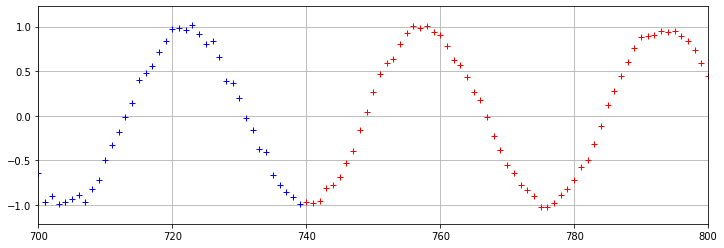

In [12]:
n_test=x_test.shape[0]
n_train = n_seq-n_test
print(n_train)
print(n_test)
    
# Display
plt.figure(figsize=(12,4))
plt.xlim(n_train-L, n_seq)
plt.grid(True)
plt.plot(data[:n_train+L].numpy(),'+b')
plt.plot(range(n_train+L, n_seq+L), predictions,'+r')
plt.show()

In [13]:
n_test=x_test.shape[0]
print(n_test)

80


## Predict the future: Compute predictions to continue the sequence

shape x_test:  torch.Size([80, 20])
seq:  tensor([[[ 0.5837],
         [ 0.3217],
         [ 0.1837],
         [ 0.0372],
         [-0.1415],
         [-0.4210],
         [-0.5085],
         [-0.5758],
         [-0.7780],
         [-0.8968],
         [-0.9471],
         [-0.9272],
         [-1.0122],
         [-1.0993],
         [-0.9547],
         [-0.9579],
         [-0.7545],
         [-0.6774],
         [-0.4716],
         [-0.3328]]])


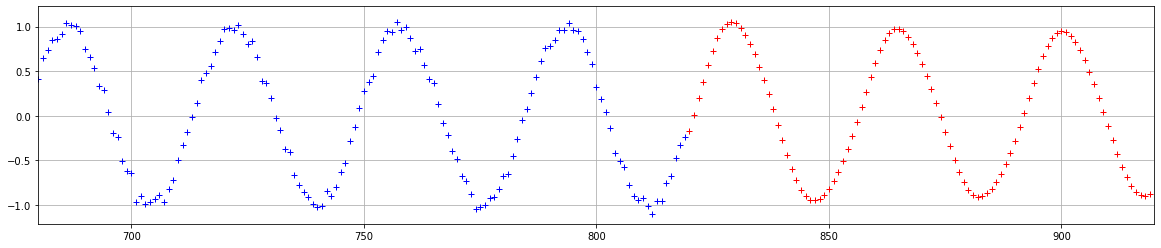

In [14]:
future = 100
print('shape x_test: ',x_test.shape)
seq = x_test[-1:,:,None].clone()
print('seq: ',seq)

preds=[]
with torch.no_grad(): # no need to compute gradients here
    for i in range(future):
        predictions = model(seq)    
        preds.append(predictions.item())
        seq[:,:-1,:] = seq[:,1:,:].clone()
        seq[:,-1,:] = predictions

# Display
plt.figure(figsize=(20,4))
plt.xlim(n_train-2*L, n_seq+L+future)
plt.grid(True)
plt.plot(data.numpy(),'+b')
plt.plot(range(n_seq+L,n_seq+L+future), preds,'+r')
plt.show()